Demonstration of GPR for PIRI data with unit trends

In [1]:
# load packages
import torch
import numpy as np
import pandas as pd
import gpytorch
from scipy.stats import norm
from typing import Optional, Tuple
from matplotlib import pyplot as plt
from gpytorch.means import LinearMean
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.kernels import ScaleKernel, RBFKernel
from statsmodels.stats.stattools import durbin_watson

Implement constant mean module and mask mean module

In [2]:
class ConstantVectorMean(gpytorch.means.mean.Mean):
    def __init__(self, d=1, prior=None, batch_shape=torch.Size(), **kwargs):
        super().__init__()
        self.batch_shape = batch_shape
        self.register_parameter(name="constantvector",\
                 parameter=torch.nn.Parameter(torch.zeros(*batch_shape, d)))
        if prior is not None:
            self.register_prior("mean_prior", prior, "constantvector")

    def forward(self, input):
        return self.constantvector[input.int().reshape((-1,)).tolist()]
    
class MaskMean(gpytorch.means.mean.Mean):
    def __init__(
        self,
        base_mean: gpytorch.means.mean.Mean,
        active_dims: Optional[Tuple[int, ...]] = None,
        **kwargs,
    ):
        super().__init__()
        if active_dims is not None and not torch.is_tensor(active_dims):
            active_dims = torch.tensor(active_dims, dtype=torch.long)
        self.active_dims = active_dims
        self.base_mean = base_mean
    
    def forward(self, x, **params):
        return self.base_mean.forward(x.index_select(-1, self.active_dims), **params)

load data

In [3]:
def load_PIRI_data():
    # read data
    data = pd.read_csv("hb_data_complete.csv", index_col=[0])

    # all zero PIRI for new zealand and netherland
    data = data.loc[~data['country'].isin(['N-ZEAL','NETHERL'])]

    countries = sorted(data.country.unique())
    years = data.year.unique()
    n = len(countries)
    m = len(years)

    # build data
    country_dict = dict(zip(countries, range(n)))
    year_dict = dict(zip(years, range(m)))

    # x is:
    # 1: year number
    # 2: country id
    # 3: AIShame (treatment indicator)
    # 4: cat_rat
    # 5: ccpr_rat
    # 6: democratic
    # 7: log(gdppc)
    # 8: log(pop)
    # 9: Civilwar2
    # 10: War
    x = torch.zeros(data.shape[0], 10)
    x[:,0] = torch.as_tensor(list(map(year_dict.get, data.year)))
    x[:,1] = torch.as_tensor(list(map(country_dict.get, data.country)))
    x[:,2] = torch.as_tensor(data.AIShame.to_numpy())
    x[:,3] = torch.as_tensor(data.cat_rat.to_numpy())
    x[:,4] = torch.as_tensor(data.ccpr_rat.to_numpy())
    x[:,5] = torch.as_tensor(data.democratic.to_numpy())
    x[:,6] = torch.as_tensor(data.log_gdppc.to_numpy())
    x[:,7] = torch.as_tensor(data.log_pop.to_numpy())
    x[:,8] = torch.as_tensor(data.Civilwar2.to_numpy())
    x[:,9] = torch.as_tensor(data.War.to_numpy())
    # x[:,10] = torch.as_tensor(data.PIRI.to_numpy())
    y = torch.as_tensor(data.PIRILead1.to_numpy()).double()

    unit_means = torch.zeros(n,)
    for i in range(n):
        unit_means[i] = y[x[:,1]==i].mean()

    return x.double(), y.double(), unit_means.double(), data, countries, years

train_x, train_y, unit_means, data, countries, years = load_PIRI_data()

Build GPR model with unit trends

In [4]:
# model specification: PIRI gp model with unit trends
# PIRI ~ AIShame + u_i(t) + cat_rat + ccpr_rat 
#            + democratic + log(gdppc) + log(pop) 
#            + Civilwar2 + War
# u_i(t) ~ GP(b_i, K_t)

class GPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = MaskMean(active_dims=1, \
               base_mean=ConstantVectorMean(d=train_x[:,1].unique().size()[0]))
        # linear mean for continuous covariates
        self.x_mean_module = MaskMean(active_dims=[2,3,4,5,6,7,8,9], base_mean=LinearMean(input_size=8, bias=False))
        # year kernel * country kernel
        self.unit_covar_module = ScaleKernel(RBFKernel(active_dims=0)*RBFKernel(active_dims=1))
        self.x_covar_module = torch.nn.ModuleList([ScaleKernel(RBFKernel(\
            active_dims=(i))) for i in [6,7]])
        self.binary_covar_module = torch.nn.ModuleList([ScaleKernel(RBFKernel(\
            active_dims=(i))) for i in [3,4,5,8,9]])
        # dummy mean for categorical covariates
        self.effect_covar_module = ScaleKernel(RBFKernel(active_dims=2))

    def forward(self, x):
        mean_x = self.mean_module(x) + self.x_mean_module(x)
        unit_covar_x = self.unit_covar_module(x)
        effect_covar_x = self.effect_covar_module(x)
        covar_x = unit_covar_x + effect_covar_x
        for i, _ in enumerate(self.x_covar_module):
            covar_x += self.x_covar_module[i](x)
        for i, _ in enumerate(self.binary_covar_module):
            covar_x += self.binary_covar_module[i](x)
        
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [5]:
import statsmodels.formula.api as sm

lm = sm.ols('PIRILead1 ~ AIShame  + cat_rat + ccpr_rat \
            + democratic + log_gdppc + log_pop \
            + Civilwar2 + War + C(year) + C(country) + PIRI', data).fit()

coefs = lm.params.to_dict()
covariate_names = ["AIShame" ,"cat_rat" , "ccpr_rat",
           "democratic",  "log_gdppc", "log_pop",
            "Civilwar2", "War"]
x_weights = list(map(coefs.get, covariate_names))


initialize model

In [8]:
likelihood = GaussianLikelihood()
model = GPModel(train_x, train_y, likelihood).double()

# initialize model parameters
hypers = {
    'mean_module.base_mean.constantvector': unit_means,
    'x_mean_module.base_mean.weights': torch.tensor(x_weights),
    'likelihood.noise_covar.noise': torch.tensor(0.25),
    'unit_covar_module.base_kernel.kernels.0.lengthscale': torch.tensor(6),
    'unit_covar_module.base_kernel.kernels.1.lengthscale': torch.tensor(0.01),
    'unit_covar_module.outputscale': torch.tensor(4),
    'x_covar_module.0.outputscale': torch.tensor(1),
    'x_covar_module.1.outputscale': torch.tensor(1),
    'binary_covar_module.0.base_kernel.lengthscale': torch.tensor(0.01),
    'binary_covar_module.1.base_kernel.lengthscale': torch.tensor(0.01),
    'binary_covar_module.2.base_kernel.lengthscale': torch.tensor(0.01),
    'binary_covar_module.3.base_kernel.lengthscale': torch.tensor(0.01),
    'binary_covar_module.4.base_kernel.lengthscale': torch.tensor(0.01),
    'binary_covar_module.0.outputscale': torch.tensor(1),
    'binary_covar_module.1.outputscale': torch.tensor(1),
    'binary_covar_module.2.outputscale': torch.tensor(1),
    'binary_covar_module.3.outputscale': torch.tensor(1),
    'binary_covar_module.4.outputscale': torch.tensor(1),
    'effect_covar_module.base_kernel.lengthscale': torch.tensor(0.01),
    'effect_covar_module.outputscale': torch.tensor(1)
}    

model.initialize(**hypers)

GPModel(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (mean_module): MaskMean(
    (base_mean): ConstantVectorMean()
  )
  (x_mean_module): MaskMean(
    (base_mean): LinearMean()
  )
  (unit_covar_module): ScaleKernel(
    (base_kernel): ProductKernel(
      (kernels): ModuleList(
        (0): RBFKernel(
          (raw_lengthscale_constraint): Positive()
        )
        (1): RBFKernel(
          (raw_lengthscale_constraint): Positive()
        )
      )
    )
    (raw_outputscale_constraint): Positive()
  )
  (x_covar_module): ModuleList(
    (0): ScaleKernel(
      (base_kernel): RBFKernel(
        (raw_lengthscale_constraint): Positive()
      )
      (raw_outputscale_constraint): Positive()
    )
    (1): ScaleKernel(
      (base_kernel): RBFKernel(
        (raw_lengthscale_constraint): Positive()
      )
      (raw_outputscale_constraint): Positive()
    )
  )
  (binary_covar_module): 

train model by optimizing hypers

In [9]:
# train model
model.train()
likelihood.train()

torch.manual_seed(12345)

# freeze length scale in the country component in unit covar
# freeze constant unit means
all_params = set(model.parameters())
final_params = list(all_params - \
            {model.unit_covar_module.base_kernel.kernels[1].raw_lengthscale, \
        #    model.unit_covar_module.raw_outputscale, \
        #    model.mean_module.base_mean.constantvector, \
        #    model.x_covar_module[0].raw_outputscale, 
        #    model.x_covar_module[1].raw_outputscale,
        #    model.likelihood.noise_covar.raw_noise,
            model.binary_covar_module[0].base_kernel.raw_lengthscale,
            model.binary_covar_module[1].base_kernel.raw_lengthscale,
            model.binary_covar_module[2].base_kernel.raw_lengthscale,
            model.binary_covar_module[3].base_kernel.raw_lengthscale,
            model.binary_covar_module[4].base_kernel.raw_lengthscale,
        #    model.binary_covar_module[0].raw_outputscale,
        #    model.binary_covar_module[1].raw_outputscale,
        #    model.binary_covar_module[2].raw_outputscale,
        #    model.binary_covar_module[3].raw_outputscale,
        #    model.binary_covar_module[4].raw_outputscale,
            model.effect_covar_module.base_kernel.raw_lengthscale})
        #    model.effect_covar_module.raw_outputscale})
optimizer = torch.optim.Adam(final_params, lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iter = 50
for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f '  % (
        i + 1, training_iter, loss.item()
    ))
    optimizer.step()

torch.save(model.state_dict(), "PIRI_GPR_model.pth")

Iter 1/50 - Loss: 2.256 
Iter 2/50 - Loss: 2.165 
Iter 3/50 - Loss: 2.085 
Iter 4/50 - Loss: 2.019 
Iter 5/50 - Loss: 1.931 
Iter 6/50 - Loss: 1.876 
Iter 7/50 - Loss: 1.847 
Iter 8/50 - Loss: 1.812 
Iter 9/50 - Loss: 1.775 
Iter 10/50 - Loss: 1.752 
Iter 11/50 - Loss: 1.740 
Iter 12/50 - Loss: 1.724 
Iter 13/50 - Loss: 1.709 
Iter 14/50 - Loss: 1.684 
Iter 15/50 - Loss: 1.677 
Iter 16/50 - Loss: 1.666 
Iter 17/50 - Loss: 1.664 
Iter 18/50 - Loss: 1.655 
Iter 19/50 - Loss: 1.655 
Iter 20/50 - Loss: 1.655 
Iter 21/50 - Loss: 1.649 
Iter 22/50 - Loss: 1.640 
Iter 23/50 - Loss: 1.630 
Iter 24/50 - Loss: 1.632 
Iter 25/50 - Loss: 1.629 
Iter 26/50 - Loss: 1.631 
Iter 27/50 - Loss: 1.632 
Iter 28/50 - Loss: 1.628 
Iter 29/50 - Loss: 1.623 
Iter 30/50 - Loss: 1.612 
Iter 31/50 - Loss: 1.610 
Iter 32/50 - Loss: 1.610 
Iter 33/50 - Loss: 1.618 
Iter 34/50 - Loss: 1.606 
Iter 35/50 - Loss: 1.607 
Iter 36/50 - Loss: 1.601 
Iter 37/50 - Loss: 1.597 
Iter 38/50 - Loss: 1.602 
Iter 39/50 - Loss: 1.

generate posterior of PIRI effects

In [10]:
model.load_state_dict(torch.load('PIRI_GPR_model.pth'))

model.train()
likelihood.train()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    out = likelihood(model(train_x))
    mu_f = out.mean
    V = out.covariance_matrix
    L = torch.linalg.cholesky(V, upper=False)

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    model.unit_covar_module.outputscale = 0
    for i,_ in enumerate(model.x_covar_module):
        model.x_covar_module[i].outputscale = 0
    for i,_ in enumerate(model.binary_covar_module):
        model.binary_covar_module[i].outputscale = 0
    effect_covar = model(train_x).covariance_matrix

# get posterior effect mean
alpha = torch.linalg.solve(L.t(),torch.linalg.solve(L,train_y-mu_f))
tmp = torch.linalg.solve(L, effect_covar)
post_effect_mean =  effect_covar @ alpha
# get posterior effect covariance
post_effect_covar = effect_covar - tmp.t() @ tmp

effect = post_effect_mean[train_x[:,2]==1].mean() - post_effect_mean[train_x[:,2]==0].mean()
effect_std = post_effect_covar.diag().mean().sqrt()
BIC = (2+4+6+1)*torch.log(torch.tensor(train_x.size()[0])) + 2*loss*train_x.size()[0]
print("effect: {:0.3f} +- {:0.3f}\n".format(effect, effect_std))
print("model evidence: {:0.3f} \n".format(-loss*train_x.size()[0]))
print("BIC: {:0.3f} \n".format(BIC))

effect: 0.038 +- 0.214

model evidence: -3372.634 

BIC: 6844.941 



In [11]:
model.load_state_dict(torch.load('PIRI_GPR_model.pth'))

model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = model(train_x)

RMSE = np.square((observed_pred.mean - train_y).detach().numpy()).mean()**0.5
print(RMSE)

/Users/yahoo/anaconda3/lib/python3.7/site-packages/gpytorch/models/exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


0.9374067306442194


Perform Durbin Watson tests for autocorrelation

In [12]:
# get unit trend wo AIShame
model.load_state_dict(torch.load('PIRI_GPR_model.pth'))
# with torch.no_grad(), gpytorch.settings.fast_pred_var():
#     model.effect_covar_module.outputscale = 0
#     unit_covar = likelihood(model(train_x)).covariance_matrix

# # get posterior unit trend mean
# alpha = torch.linalg.solve(L.t(),torch.linalg.solve(L,train_y-mu_f))
# tmp = torch.linalg.solve(L, unit_covar)
# post_unit_mean = mu_f + unit_covar @ alpha + post_effect_mean

model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    out = likelihood(model(train_x))
    mu_f = out.mean.numpy()

# DW-test for sample size = 18 and 8 regressors.
dL = 0.407 # 0.32
dU = 2.668 # 2.87
n = len(countries)
DW_results = np.zeros((n,))
for i in range(n):
    mask = data.country==countries[i]
    mask = mask.to_list()
    res = train_y[mask] - mu_f[mask] # post_unit_mean[mask]
    DW_results[i] = durbin_watson(res.detach().numpy())

print("{} out of {} residuals are positively correlated.\n".format(np.sum(DW_results<=dL),n))
print("{} out of {} residuals are negatively correlated.\n".format(np.sum(DW_results>=dU),n))
print("{} out of {} residuals are not correlated.\n".format(np.sum((DW_results>dL) & (DW_results<dU)),n))
    

0 out of 138 residuals are positively correlated.

17 out of 138 residuals are negatively correlated.

121 out of 138 residuals are not correlated.



plot fitted mean trend and CI

In [13]:
model.load_state_dict(torch.load('PIRI_GPR_model.pth'))

model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    out = model(train_x)
    mu_f = out.mean.numpy()
    lower, upper = out.confidence_region()

results = pd.DataFrame({"gpr_mean":mu_f})
results['true_y'] = train_y
results['gpr_lwr'] = lower
results['gpr_upr'] = upper
results['year'] = years[train_x[:,0].numpy().astype(int)]
results['country'] = [countries[i] for i in train_x[:,1].numpy().astype(int)]
print(results.head())
results.to_csv("./results/PIRI_fitted_gpr.csv",index=False) #save to file

   gpr_mean  true_y   gpr_lwr   gpr_upr  year country
0  0.591223     0.0 -0.896948  2.079394  1983     USA
1  0.605753     1.0 -0.864731  2.076238  1984     USA
2  0.685171     1.0 -0.772356  2.142697  1985     USA
3  0.636433     0.0 -0.804801  2.077667  1986     USA
4  0.707243     1.0 -0.723132  2.137617  1987     USA


use autogradient to generate posterior variance of marginal effects in PIRI by small batches

In [33]:
model.load_state_dict(torch.load('PIRI_GPR_model.pth'))

model.eval()
likelihood.eval()

df_std = np.zeros((train_x.size(0),train_x.size(1)))
x_grad = np.zeros((train_x.size(0),train_x.size(1)))

n_samples = 100
sampled_dydtest_x = np.zeros((n_samples, train_x.size(0),train_x.size(1)))

# small batches of size 100
for i in range(train_x.size(0)//100):
    with gpytorch.settings.fast_pred_var():
        test_x = train_x[(i*100):(i*100+100)].clone().detach().requires_grad_(True)
        observed_pred = model(test_x)
        dydtest_x = torch.autograd.grad(observed_pred.mean.sum(), test_x, retain_graph=True)[0]
        x_grad[(i*100):(i*100+100)] = dydtest_x
        loss = mll(observed_pred, train_y[(i*100):(i*100+100)])

        sampled_pred = observed_pred.rsample(torch.Size([n_samples]))
        sampled_dydtest_x[:,(i*100):(i*100+100),:] = torch.stack([torch.autograd.grad(pred.sum(), test_x, retain_graph=True)[0] for pred in sampled_pred])
        # df_std[(i*100):(i*100+100)] = sampled_dydtest_x.std(0)
        
# last 100 rows
with gpytorch.settings.fast_pred_var():
    test_x = train_x[(100*i+100):].clone().detach().requires_grad_(True)
    observed_pred = model(test_x)
    dydtest_x = torch.autograd.grad(observed_pred.mean.sum(), test_x, retain_graph=True)[0]
    x_grad[(100*i+100):] = dydtest_x
    loss = mll(observed_pred, train_y[(100*i+100):])

    sampled_pred = observed_pred.rsample(torch.Size([n_samples]))
    sampled_dydtest_x[:,(100*i+100):,:] = torch.stack([torch.autograd.grad(pred.sum(), test_x, retain_graph=True)[0] for pred in sampled_pred])
    # df_std[(100*i+100):] = sampled_dydtest_x.std(0)
    

In [81]:
sampled_dydtest_x.mean(1).mean(0)

array([ 1.04636321e-02, -3.95240931e-09,  2.45199088e-02,  3.47392238e-02,
        3.31899251e-01, -6.23536537e-01,  2.38673110e-02,  2.40293219e-02,
        6.29372074e-01,  3.54057894e-01])

In [82]:
x_grad.mean(0)

array([ 1.03506718e-02,  4.32058515e-12,  2.45199087e-02,  3.47392240e-02,
        3.31899251e-01, -6.23536538e-01,  1.96147893e-02,  2.42922898e-02,
        6.29372074e-01,  3.54057894e-01])

accesse marginal effects of regressors

In [78]:
# est_std = (df_std).mean(axis=0).round(decimals=5)
# est_std = np.sqrt((sampled_dydtest_x.std(1)**2).mean(0) + (sampled_dydtest_x.mean(1)**2).mean(0) \
#                  - sampled_dydtest_x.mean(1).mean(0)**2 )
est_std = np.sqrt(sampled_dydtest_x.mean(1).std(0)**2 + sampled_dydtest_x.std(1).mean(0)**2)

est_std.round(decimals=5)
results = pd.DataFrame({"x": covariate_names, \
                        'est_mean': x_grad.mean(axis=0)[2:10],
                        'est_std': est_std[2:10]})
results["t"] = results['est_mean'].values/results['est_std'].values
results["pvalue"] = 1 - norm.cdf(np.abs(results["t"].values))
print(results)

            x  est_mean     est_std             t        pvalue
0     AIShame  0.024520    0.001020     24.032447  0.000000e+00
1     cat_rat  0.034739    0.006008      5.781717  3.697111e-09
2    ccpr_rat  0.331899    0.002082    159.442311  0.000000e+00
3  democratic -0.623537    0.000778   -801.125493  0.000000e+00
4   log_gdppc  0.019615   62.853479      0.000312  4.998755e-01
5     log_pop  0.024292  168.152711      0.000144  4.999424e-01
6   Civilwar2  0.629372    0.000076   8304.203301  0.000000e+00
7         War  0.354058    0.000008  46040.883349  0.000000e+00


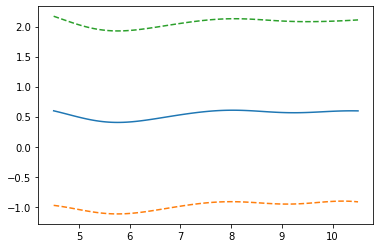

In [63]:
model.load_state_dict(torch.load('PIRI_GPR_model.pth'))

model.eval()
likelihood.eval()

test_x = train_x[0:101].clone().detach().requires_grad_(False)
for i in range(100):
    test_x[1+i] = test_x[0].clone().detach().requires_grad_(True)
test_x[:,6] = torch.linspace(4.5,10.5,101)

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    out = model(test_x)
    mu_f = out.mean.numpy()
    lower, upper = out.confidence_region()
    plt.plot(test_x[:,6].detach().numpy(), mu_f)
    plt.plot(test_x[:,6].detach().numpy(), lower.numpy(), '--')
    plt.plot(test_x[:,6].detach().numpy(), upper.numpy(), '--')
    plt.xlabel("log_gdppc")

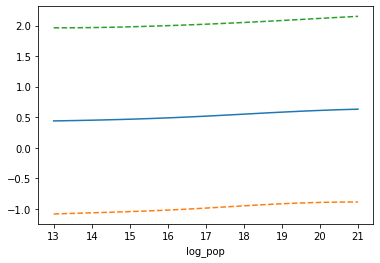

In [64]:
model.load_state_dict(torch.load('PIRI_GPR_model.pth'))

model.eval()
likelihood.eval()

test_x = train_x[0:101].clone().detach().requires_grad_(False)
for i in range(100):
    test_x[1+i] = test_x[0].clone().detach().requires_grad_(True)
test_x[:,7] = torch.linspace(13,21,101)

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    out = model(test_x)
    mu_f = out.mean.numpy()
    lower, upper = out.confidence_region()
    plt.plot(test_x[:,7].detach().numpy(), mu_f)
    plt.plot(test_x[:,7].detach().numpy(), lower.numpy(), '--')
    plt.plot(test_x[:,7].detach().numpy(), upper.numpy(), '--')
    plt.xlabel("log_pop")